# Time Series analysis of **Cisco Webex Cpu Usage, Memory Consumption & Disk Utilisation**

The general process for applying models is the following:
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the model based on the data
* Use the model to make predictions

In [2]:
import warnings
warnings.filterwarnings('ignore')
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df=pd.read_csv('Combining_All_data.csv')
df.head()

,date,mem,cpu,disk
0,2019-10-01,29.199996,86733.028994,9134.104410
1,2019-10-02,29.289939,91516.976697,9149.066883
2,2019-10-03,29.482761,87388.898674,9186.874863
3,2019-10-04,29.580590,90800.392898,9198.127033
4,2019-10-05,29.736559,85347.468772,9202.876041


In [4]:
df.tail()

,date,mem,cpu,disk
206,2020-04-24,31.952609,154085.732403,11236.031371
207,2020-04-25,31.086370,136860.612194,11174.189173
208,2020-04-26,30.653181,83167.057978,11231.877344
209,2020-04-27,31.395337,70573.773125,11466.869589
210,2020-04-28,31.542723,90463.329288,11529.125060


# Convert Date into pandas Datetime

In [5]:
df['date']=pd.to_datetime(df['date'])
df.head()

,date,mem,cpu,disk
0,2019-10-01,29.199996,86733.028994,9134.104410
1,2019-10-02,29.289939,91516.976697,9149.066883
2,2019-10-03,29.482761,87388.898674,9186.874863
3,2019-10-04,29.580590,90800.392898,9198.127033
4,2019-10-05,29.736559,85347.468772,9202.876041


In [6]:
df.set_index('date',inplace=True)
df.head()

,mem,cpu,disk
date,,,
2019-10-01,29.199996,86733.028994,9134.104410
2019-10-02,29.289939,91516.976697,9149.066883
2019-10-03,29.482761,87388.898674,9186.874863
2019-10-04,29.580590,90800.392898,9198.127033
2019-10-05,29.736559,85347.468772,9202.876041


In [7]:
df.describe()

,mem,cpu,disk
count,211.000000,211.000000,211.000000
mean,32.158141,84585.573250,9702.107520
std,1.493870,28601.704302,730.747071
min,29.199996,47614.760705,8547.100428
25%,30.949427,58252.463332,9234.014382
50%,32.147824,84580.981483,9497.547926
75%,33.444300,92231.659596,9880.660696
max,34.709204,155155.079995,11614.454654


# Visualizing the Memory

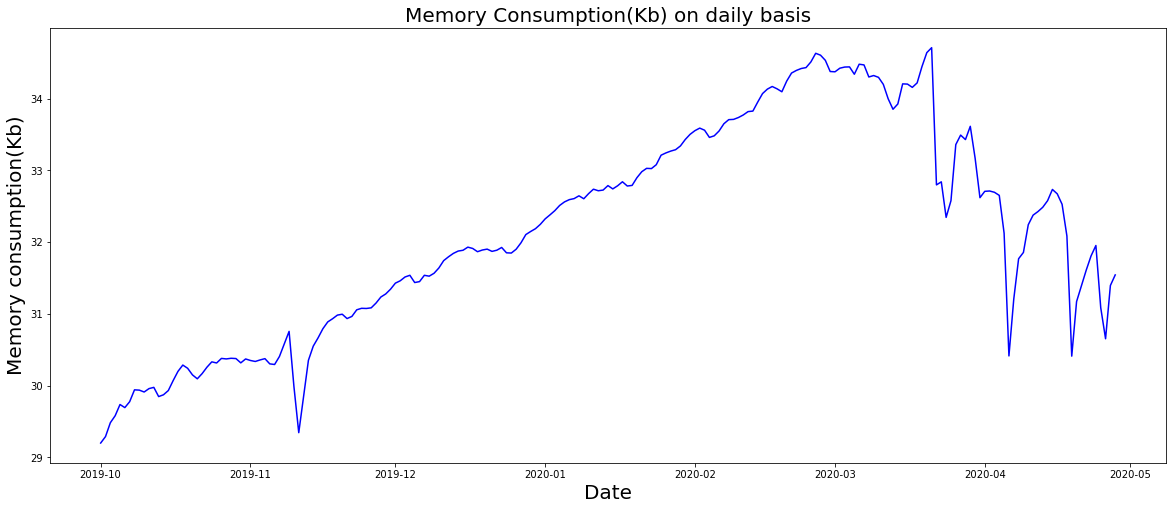

In [8]:
plt.figure(figsize = (20, 8))
plt.plot(df.index, df.mem, color = 'blue')
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Memory consumption(Kb)', fontsize = 20)
plt.title("Memory Consumption(Kb) on daily basis", fontsize = 20)
plt.show()

# Visualizing the Disk

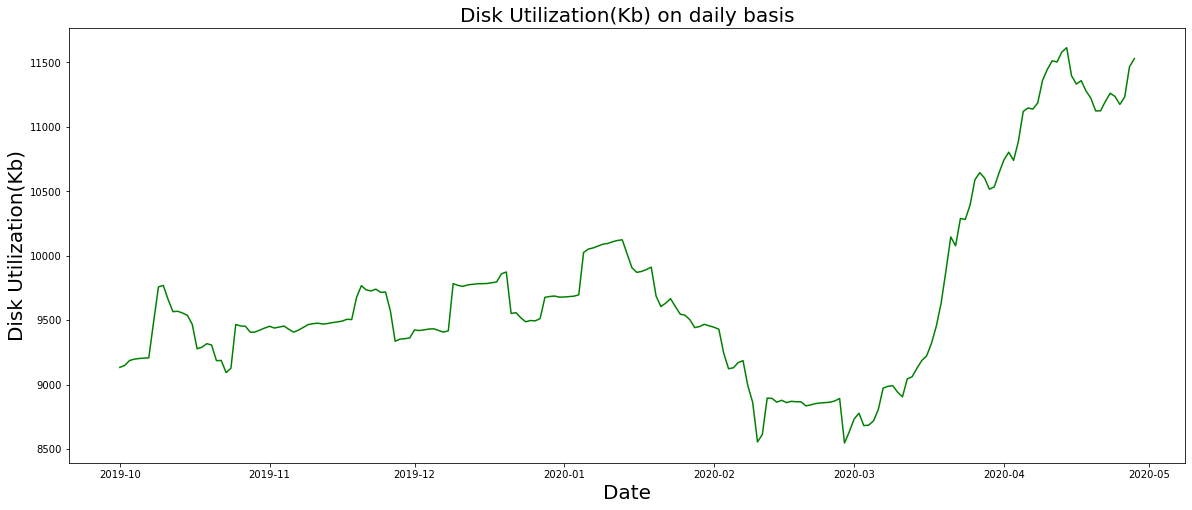

In [9]:
plt.figure(figsize = (20, 8))
plt.plot(df.index, df.disk, color = 'green')
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Disk Utilization(Kb)', fontsize = 20)
plt.title("Disk Utilization(Kb) on daily basis", fontsize = 20)
plt.show()

# Visualizing the CPU

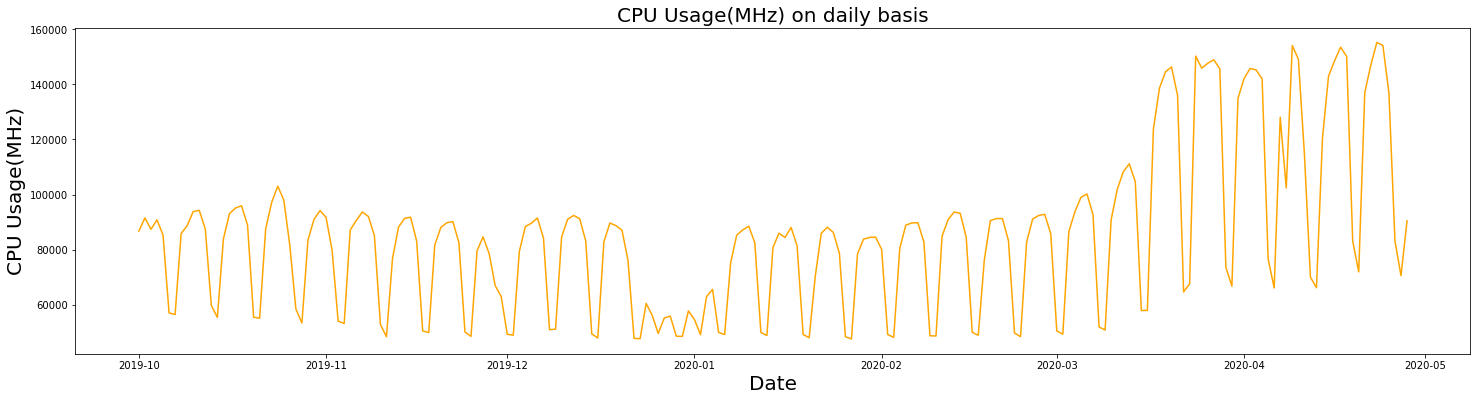

In [10]:
plt.figure(figsize = (25, 6))
plt.plot(df.index, df.cpu, color = 'orange')
plt.xlabel('Date', fontsize = 20)
plt.ylabel('CPU Usage(MHz)', fontsize = 20)
plt.title('CPU Usage(MHz) on daily basis', fontsize = 20)
plt.show()

# Visualizing altogether

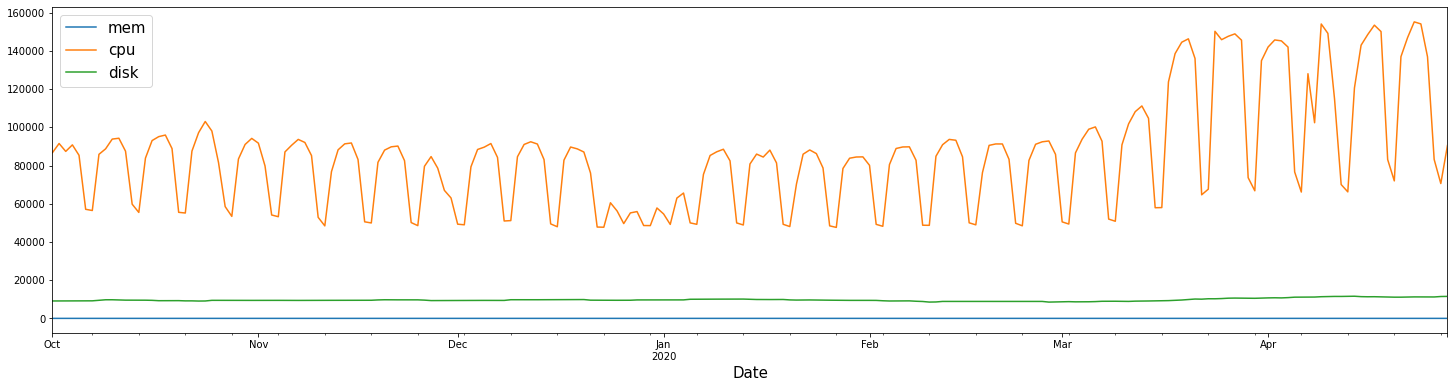

In [11]:
plt.figure(figsize = (25, 6))
df.plot(ax = plt.gca())
plt.legend(fontsize=15)
plt.xlabel('Date', fontsize = 15)
plt.show()

# Visualizing Normalized data altogether

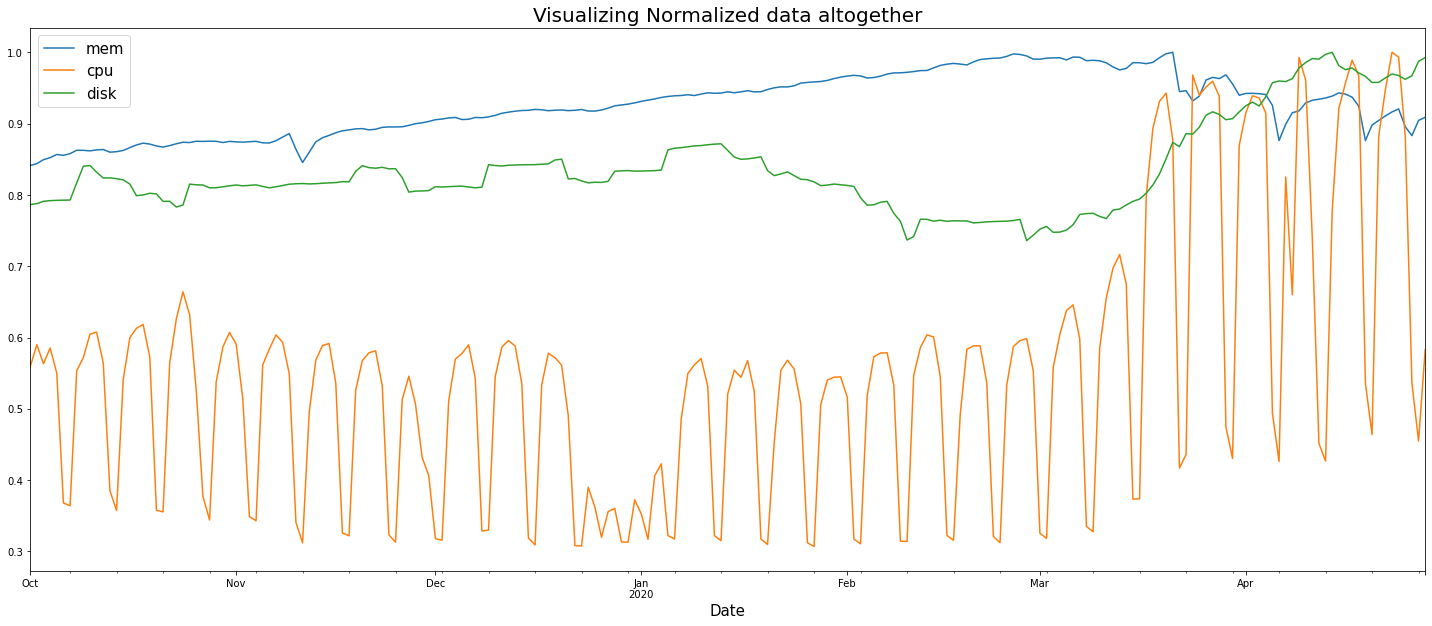

In [12]:
new_df = df.copy()
new_df.mem = new_df.mem/(max(new_df.mem))
new_df.disk = new_df.disk/(max(new_df.disk))
new_df.cpu = new_df.cpu/(max(new_df.cpu))

plt.figure(figsize = (25, 10))
new_df.plot(ax = plt.gca())
plt.legend(fontsize=15, loc='upper left')
plt.xlabel('Date', fontsize = 15)
plt.title('Visualizing Normalized data altogether', fontsize=20)
plt.show()

# Extracting CPU usage from the data

In [13]:
cpu = pd.DataFrame(df.cpu)
X_train = cpu[cpu.index <= '2020-01-01'] #length = 93 days
X_test = cpu[cpu.index >= '2020-01-01'] 
X_test = X_test[X_test.index < '2020-02-02'] #Length = 32 days

# Visualising Training & Testing data

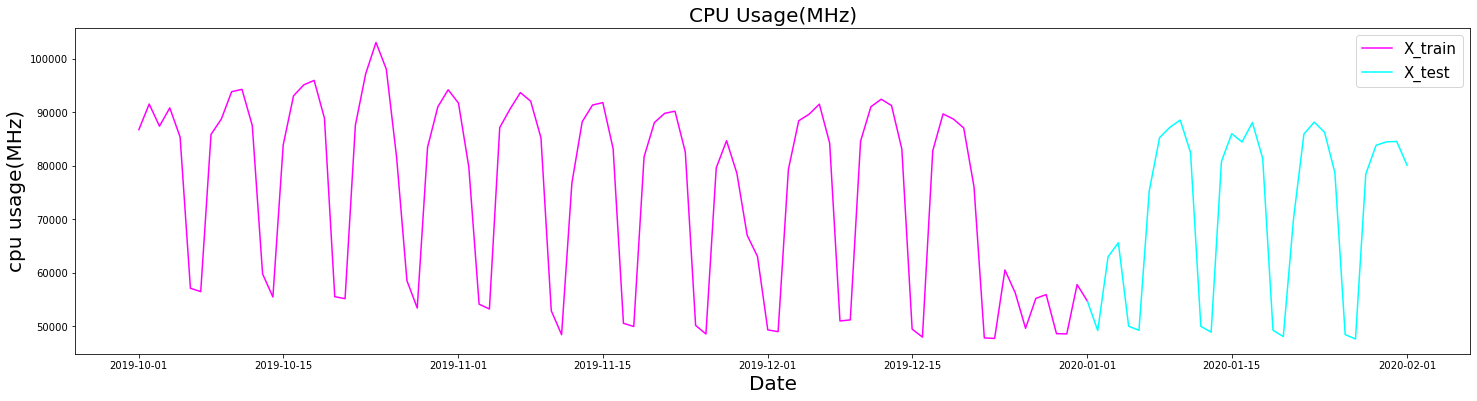

In [14]:
plt.figure(figsize = (25, 6))
plt.plot(X_train, color = 'magenta', label = 'X_train')
plt.plot(X_test, color = 'cyan', label = 'X_test')
plt.legend(fontsize = 15)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('cpu usage(MHz)', fontsize = 20)
plt.title('CPU Usage(MHz)', fontsize=20)
plt.show()

# Testing For Stationarity

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
# test_result=adfuller(cpu)

In [17]:
def adfuller_test(metric):
    result=adfuller(metric)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [18]:
adfuller_test(X_train)

ADF Test Statistic : -0.2671549345346272
p-value : 0.9300290763051544
#Lags Used : 8
Number of Observations Used : 84
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


# Differencing(Best shift value comes out to be 5)

In [19]:
X_train['cpu_first_difference'] = X_train['cpu'] - X_train['cpu'].shift(1)

In [20]:
X_train.head()

,cpu,cpu_first_difference
date,,
2019-10-01,86733.028994,NaN
2019-10-02,91516.976697,4783.947703
2019-10-03,87388.898674,-4128.078024
2019-10-04,90800.392898,3411.494224
2019-10-05,85347.468772,-5452.924126


In [21]:
# df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12)
# df.head(14)

# Again testing dickey fuller test

In [22]:
adfuller_test(X_train['cpu_first_difference'].dropna())

ADF Test Statistic : -4.160776162199902
p-value : 0.0007672056792440172
#Lags Used : 7
Number of Observations Used : 84
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


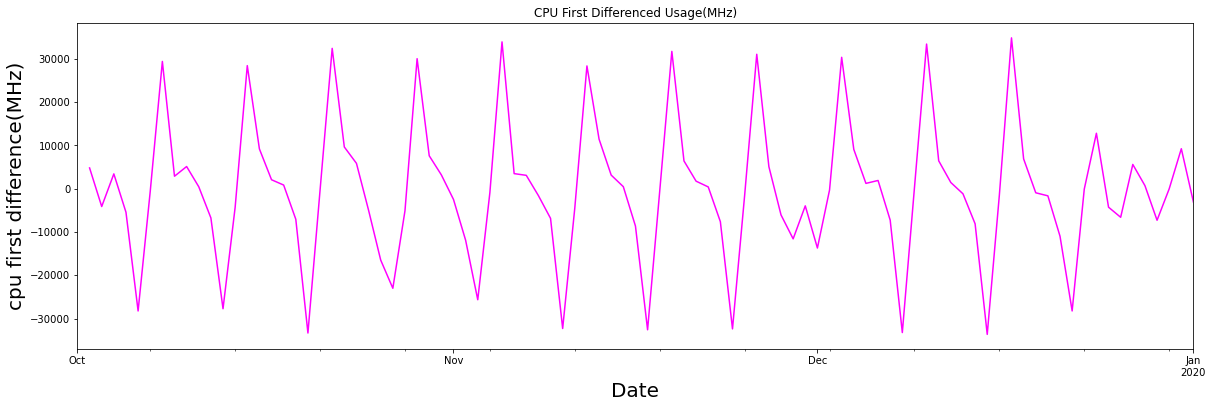

In [23]:
plt.figure(figsize = (20,6))
X_train['cpu_first_difference'].plot(color = 'magenta')
plt.xlabel('Date', fontsize = 20)
plt.ylabel('cpu first difference(MHz)', fontsize = 20)
plt.title('CPU First Differenced Usage(MHz)')
plt.show()

# Applying Auto Regressive Integerated Moving Average Model

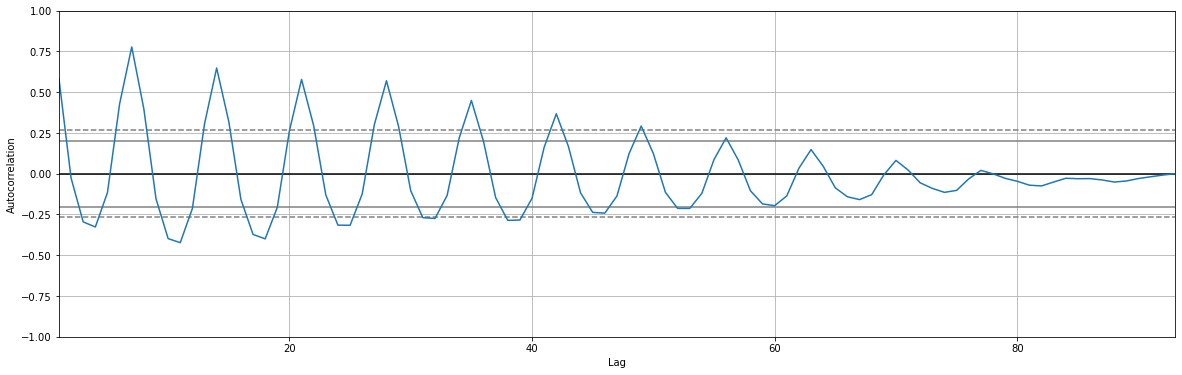

In [30]:
plt.figure(figsize=(20,6))
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(X_train['cpu'])
plt.show()

### Final Thoughts on Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.
    
    p,d,q
    p AR model lags
    d differencing
    q MA lags

In [31]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

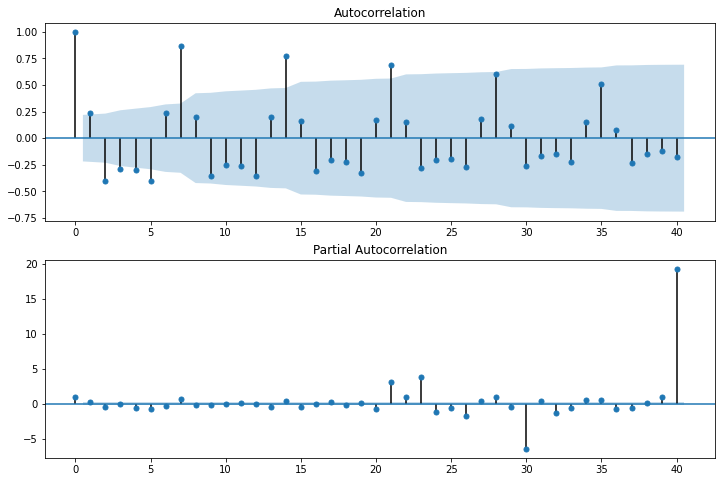

In [35]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(X_train['cpu_first_difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(X_train['cpu_first_difference'].iloc[13:],lags=40,ax=ax2)

# Applying ARIMA

In [63]:
from statsmodels.tsa.arima_model import ARIMA
warnings.filterwarnings('ignore')
model=ARIMA(X_train['cpu'],order=(2,1,1))
model_fit=model.fit()

In [64]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.cpu   No. Observations:                   92
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -989.437
Method:                       css-mle   S.D. of innovations          11022.584
Date:                Mon, 11 May 2020   AIC                           1988.874
Time:                        13:34:17   BIC                           2001.483
Sample:                    10-02-2019   HQIC                          1993.963
                         - 01-01-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -234.6307     57.567     -4.076      0.000    -347.460    -121.801
ar.L1.D.cpu     0.8488      0.082     10.368      0.000       0.688       1.009
ar.L2.D.cpu    -0.5998      0.081     -7.423      0.000      -0.758      -0.441
ma.L1.D.cpu    -1.0000      0.040    -24.731      0.000      -1.079      -0.921
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.7075           -1.0800j            1.2912           -0.1577
AR.2            0.7075           +1.0800j            1.2912            0.1577
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

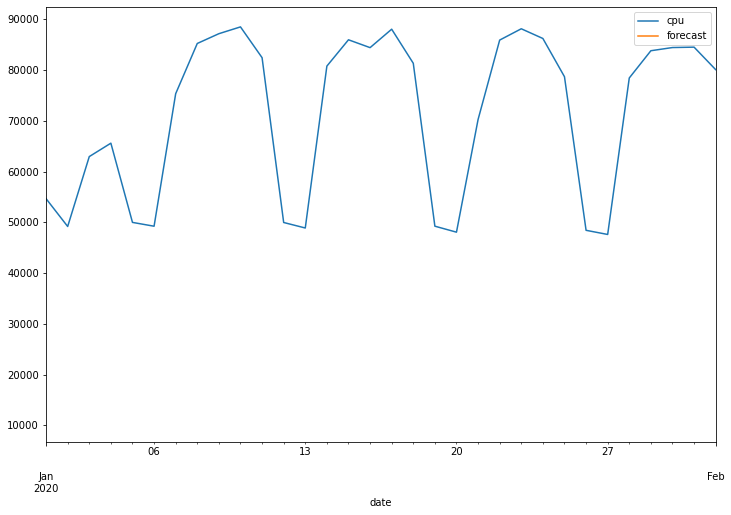

In [66]:
X_test['forecast']=model_fit.predict()
X_test[['cpu','forecast']].plot(figsize=(12,8))

In [67]:
X_test.head()

,cpu,forecast
date,,
2020-01-01,54665.301767,10613.294555
2020-01-02,49188.947357,NaN
2020-01-03,62961.256980,NaN
2020-01-04,65603.719289,NaN
2020-01-05,49992.476525,NaN


# Predicting on X_trian

In [79]:
import statsmodels.api as sm
sarimax = sm.tsa.statespace.SARIMAX(X_train['cpu'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
sarimax_prediction = sarimax.fit()

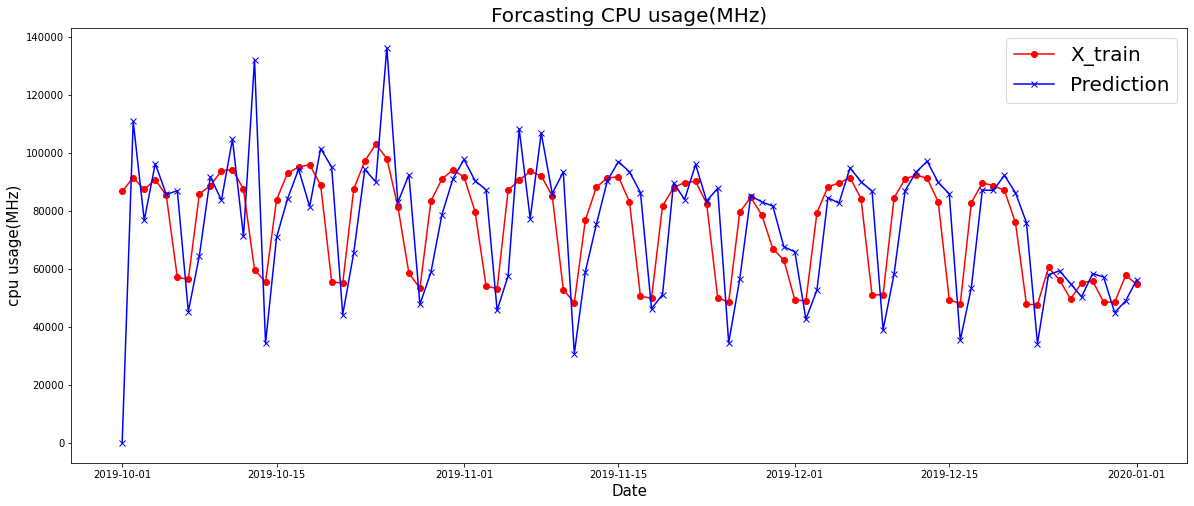

In [93]:
X_train['prediction'] = sarimax_prediction.predict()

plt.figure(figsize=(20,8))
plt.plot(X_train['cpu'], color = 'red', marker = 'o', label = 'X_train')
plt.plot(X_train['prediction'], color = 'blue', marker = 'x', label = 'Prediction')
plt.legend(fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('cpu usage(MHz)', fontsize = 15)
plt.title('Forcasting CPU usage(MHz)', fontsize = 20)
plt.show()

# Forecasting Future

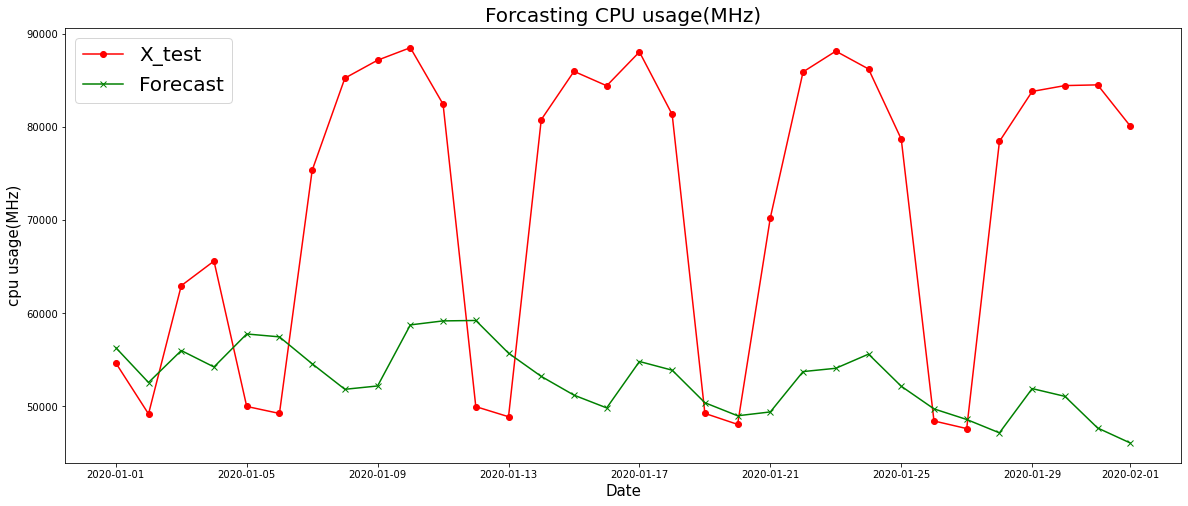

In [96]:
X_test['forecast'] = results.predict(start = 92, end = 125)  

plt.figure(figsize=(20,8))
plt.plot(X_test['cpu'], color = 'red', marker = 'o', label = 'X_test')
plt.plot(X_test['forecast'], color = 'green', marker = 'x', label = 'Forecast')
plt.legend(fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('cpu usage(MHz)', fontsize = 15)
plt.title('Forcasting CPU usage(MHz)', fontsize = 20)
plt.show()

In [95]:
X_test.head()

,cpu,forecast
date,,
2020-01-01,54665.301767,56306.316640
2020-01-02,49188.947357,54831.693267
2020-01-03,62961.256980,58046.310879
2020-01-04,65603.719289,56359.261218
2020-01-05,49992.476525,59874.786303
